In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
matplotlib.style.use('ggplot')
from torchvision.datasets import MNIST
import os
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy

# other  libraries...!!!
%matplotlib inline
import argparse
from skimage.util import random_noise

import time

In [2]:
#############################
#        CLASS              #
############################


# output features for the encoder and input features for the decoder
features = 60
# define a simple linear VAE

class LinearVAE(nn.Module):
    
    # 4 linear layers. MINST data set 28*28*1 image = 784. 
    
    def __init__(self):
        
        super(LinearVAE, self).__init__()
        #FUNCTIONS FOR ENCODER
        self.fc1 = nn.Linear(784, 600)
        self.fc2 = nn.Linear(600, 400)
        self.fc3 = nn.Linear(400, 250)
        self.fc4 = nn.Linear(250, features*2)
        #FUNCTIONS FOR DECODER
        self.fc5 = nn.Linear(features, 250)
        self.fc6 = nn.Linear(250, 400)
        self.fc7 = nn.Linear(400, 600)
        self.fc8 = nn.Linear(600, 784)



    #ENCODER
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2)) # pass the input through the VAE’s encoder layers.
        h4 = self.fc4(h3)
        h4=h4.view(-1, 2, features)
        return h4
    #DECODER  
    def decode(self, z):
        h5 = F.relu(self.fc5(z))
        h6 = F.relu(self.fc6(h5))
        h7 = F.relu(self.fc7(h6))
        h8 = torch.sigmoid(self.fc8(h7))
        return h8
    #REPARAMETERIZE
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #Returns a new tensor with the exponential of the elements of the input tensor input
        std = torch.exp(0.5*log_var) 
        #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    #FORWARD FUNCTION  
    def forward(self, x,high_res_image):
        self.high_res_image = high_res_image
        # encoding
         #Applies the rectified linear unit function element-wise.
        x_org = x
        x = self.encode(x)  # pass the input through the VAE’s encoder layers.
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #latent vector 
        # decoding, pass the latent vector through the first decoder. 
        #then get the reconstruction of the inputs by giving the outputs as unputs to the second decoder layer. 
        reconstruction = self.decode(z) #self.dec2(x))
        
        BCE, KLD, loss = self.elbo(x_org, reconstruction, mu, log_var)
        
        return reconstruction, mu, log_var , BCE, KLD, loss, z
    
    #LOSS FUNCTION  
    def elbo(self, x, reconstruction, mu, log_var,b1=1,b2=0.75) :
        criterion = nn.BCELoss(reduction='sum')
        BCE = criterion(reconstruction, self.high_res_image)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = b1 * KLD + BCE 
        
        return BCE, KLD, loss
        

In [3]:
#############################
#        BINARIZATION       #
############################
def dynamic_binarization(image: torch.Tensor) -> torch.Tensor:
  
  image = torch.bernoulli(image)
  
  return image

In [4]:
#############################
#        PARAMETERS          #
############################

batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def pixalate_image(image, scale_percent = 40):
  image = image.numpy()#image.permute(1, 2, 0).numpy()
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)+1
  height = int(small_image.shape[0] * 100 / scale_percent)+1
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image,image

In [6]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

In [7]:
from torchvision.datasets import STL10

class MNIST(MNIST):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(img)

    if self.transform is not None:
        img = self.transform(img)
        

    if self.transform is not None:
        target = self.transform(target)
        

    return img, target

In [8]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor()
    
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor()
                               
                            ])


# train and validation data
train_data = MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=target_transform
)


val_data = MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=target_transform
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [9]:
# Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

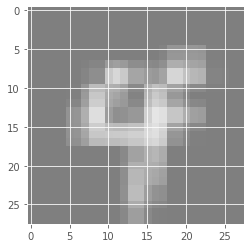

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[1]))


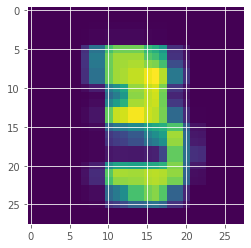

In [ ]:

#choose witch image you want to see from 60000
single_image = 1

#take the labels for each train image 


with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    #data = data.to(device)
    x = images[1].size()
    # Reshape image
    plt.imshow(images[1].view(28,28))

white_torch = images[1]

torchvision.transforms.ToPILImage()(white_torch)

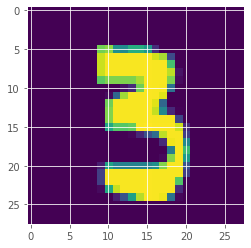

In [ ]:
plt.imshow(labels[1].view(28,28))

In [ ]:
dataiter = iter(train_loader)
low, high = next(dataiter)


compare_images(high[1].view(28,28).numpy(),low[1].view(28,28).numpy())

(65.08690729236642, 0.7426572125049337)

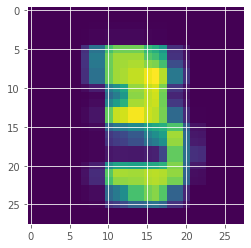

In [ ]:
plt.imshow(images[1].view(28,28))

In [ ]:
#############################
#     TRAINING FUNCTION     #
############################

def fit(model, dataloader):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0
  
    
    
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, high_res = data
        
        data = data.to(device)
        data = data.view(data.size(0), -1)

        high_res = high_res.to(device)
        high_res = high_res.view(data.size(0), -1)

        optimizer.zero_grad()
        start = time.time()
        reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
        
        
        running_loss +=   loss.item()
        bce_running_loss += bce.item()
        kl_running_loss += kl.item()
        loss.backward()
        optimizer.step()
        end = time.time()
        #print("Time inside fit: ", end-start)
    train_loss = running_loss/len(dataloader.dataset)
    train_loss_bce = bce_running_loss/len(dataloader.dataset)
    train_loss_kl = kl_running_loss/len(dataloader.dataset)
    
    

   
    return train_loss, train_loss_bce, train_loss_kl

"""### The Validation Function"""

#############################
#     VALIDATE FUNCTION     #
############################
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            data = data.view(data.size(0), -1)

            high_res = high_res.to(device)
            high_res = high_res.view(data.size(0), -1)

            reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
            
            running_loss += loss.item()
            bce_running_loss += bce.item()
            kl_running_loss += kl.item()
            

            
    val_loss = running_loss/len(dataloader.dataset)
    val_loss_bce = bce_running_loss/len(dataloader.dataset)
    val_loss_kl = kl_running_loss/len(dataloader.dataset)
    


    return val_loss, val_loss_bce, val_loss_kl


In [ ]:
"""#### Initializing the Model, the Optimizer and the Loss Function"""
epochs = 100
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
#############################
#            RUN            #
############################

train_loss = []
train_loss_bce = []
train_loss_kl = []
train_loss_mse = []

val_loss = []
val_loss_bce = []
val_loss_kl = []
val_loss_mse = []

start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_loss_bce, train_epoch_loss_kl= fit(model, train_loader)    
    end = time.time()
    
    val_epoch_loss, val_epoch_loss_bce, val_epoch_loss_kl = validate(model, test_loader)

    
    print(end-start)
    train_loss.append(train_epoch_loss)
    train_loss_bce.append(train_epoch_loss_bce)
    train_loss_kl.append(train_epoch_loss_kl)
    
    
    val_loss.append(val_epoch_loss)
    val_loss_bce.append(val_epoch_loss_bce)
    val_loss_kl.append(val_epoch_loss_kl) 
      
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")





Epoch 1 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

13.764955282211304
Train Loss: 177.7040
Val Loss: 148.5403
Epoch 2 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

31.94765567779541
Train Loss: 138.0852
Val Loss: 131.1118
Epoch 3 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

47.47728157043457
Train Loss: 127.5914
Val Loss: 123.6381
Epoch 4 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

58.86649179458618
Train Loss: 121.7384
Val Loss: 118.6058
Epoch 5 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

70.48773264884949
Train Loss: 118.6665
Val Loss: 116.6671
Epoch 6 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

82.02363777160645
Train Loss: 116.8905
Val Loss: 115.5436
Epoch 7 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

93.57563400268555
Train Loss: 115.4378
Val Loss: 114.9402
Epoch 8 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

105.17828226089478
Train Loss: 114.5475
Val Loss: 114.1011
Epoch 9 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

117.71083307266235
Train Loss: 113.6448
Val Loss: 112.9832
Epoch 10 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

129.5913016796112
Train Loss: 112.9276
Val Loss: 113.4116
Epoch 11 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

141.40893125534058
Train Loss: 112.4505
Val Loss: 111.8032
Epoch 12 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

153.17210388183594
Train Loss: 111.9321
Val Loss: 111.5796
Epoch 13 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

164.9804298877716
Train Loss: 111.4965
Val Loss: 111.3823
Epoch 14 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

176.73747897148132
Train Loss: 111.1245
Val Loss: 111.6790
Epoch 15 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

188.68048334121704
Train Loss: 110.6710
Val Loss: 110.7440
Epoch 16 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

200.55003190040588
Train Loss: 110.3999
Val Loss: 110.6615
Epoch 17 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

212.43758273124695
Train Loss: 110.1955
Val Loss: 110.8429
Epoch 18 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

224.35736751556396
Train Loss: 109.8582
Val Loss: 110.4094
Epoch 19 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

236.19247031211853
Train Loss: 109.6312
Val Loss: 110.4734
Epoch 20 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

248.17763566970825
Train Loss: 109.4211
Val Loss: 110.1443
Epoch 21 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

260.0271327495575
Train Loss: 109.1857
Val Loss: 110.7393
Epoch 22 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

273.0669388771057
Train Loss: 108.9578
Val Loss: 110.0804
Epoch 23 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

285.0780146121979
Train Loss: 108.8067
Val Loss: 109.8825
Epoch 24 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

296.9903392791748
Train Loss: 108.6478
Val Loss: 110.5986
Epoch 25 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

309.2084665298462
Train Loss: 108.4851
Val Loss: 110.2414
Epoch 26 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

321.1608850955963
Train Loss: 108.3558
Val Loss: 109.6161
Epoch 27 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

333.04377365112305
Train Loss: 108.2207
Val Loss: 110.0466
Epoch 28 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

345.1156873703003
Train Loss: 108.0706
Val Loss: 109.7231
Epoch 29 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

357.099680185318
Train Loss: 107.8721
Val Loss: 109.7859
Epoch 30 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

369.13719606399536
Train Loss: 107.8260
Val Loss: 109.7824
Epoch 31 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

381.04204201698303
Train Loss: 107.7444
Val Loss: 109.8227
Epoch 32 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

392.9653482437134
Train Loss: 107.5855
Val Loss: 109.6909
Epoch 33 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

404.89349389076233
Train Loss: 107.5132
Val Loss: 109.2780
Epoch 34 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

416.7768054008484
Train Loss: 107.2752
Val Loss: 109.2582
Epoch 35 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

428.7913680076599
Train Loss: 107.2682
Val Loss: 109.4073
Epoch 36 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

440.9454369544983
Train Loss: 107.1949
Val Loss: 109.4003
Epoch 37 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

452.97854113578796
Train Loss: 107.0262
Val Loss: 109.2701
Epoch 38 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

464.92251896858215
Train Loss: 106.9884
Val Loss: 109.3181
Epoch 39 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

476.8285081386566
Train Loss: 106.8891
Val Loss: 109.2789
Epoch 40 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

488.79557728767395
Train Loss: 106.8789
Val Loss: 109.5898
Epoch 41 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

500.81742548942566
Train Loss: 106.7586
Val Loss: 109.0461
Epoch 42 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

512.8033044338226
Train Loss: 106.6376
Val Loss: 109.7292
Epoch 43 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

526.2028460502625
Train Loss: 106.6421
Val Loss: 109.3142
Epoch 44 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

538.0886929035187
Train Loss: 106.5108
Val Loss: 109.6549
Epoch 45 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

549.9863657951355
Train Loss: 106.4252
Val Loss: 108.9119
Epoch 46 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

561.9748480319977
Train Loss: 106.3175
Val Loss: 109.1197
Epoch 47 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

573.8922915458679
Train Loss: 106.3296
Val Loss: 108.8016
Epoch 48 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

585.9331841468811
Train Loss: 106.2243
Val Loss: 109.0494
Epoch 49 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

597.936600446701
Train Loss: 106.1622
Val Loss: 108.9164
Epoch 50 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

610.179126739502
Train Loss: 106.1783
Val Loss: 109.0025
Epoch 51 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

622.5408639907837
Train Loss: 106.0429
Val Loss: 108.7189
Epoch 52 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

634.6243278980255
Train Loss: 105.9701
Val Loss: 108.7157
Epoch 53 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

646.6346199512482
Train Loss: 105.9200
Val Loss: 108.6875
Epoch 54 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

658.6356728076935
Train Loss: 105.9178
Val Loss: 109.1789
Epoch 55 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

670.7804160118103
Train Loss: 105.8002
Val Loss: 108.9529
Epoch 56 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

682.9487679004669
Train Loss: 105.7458
Val Loss: 109.0946
Epoch 57 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

695.0781848430634
Train Loss: 105.7486
Val Loss: 109.1691
Epoch 58 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

707.2360763549805
Train Loss: 105.7021
Val Loss: 109.9260
Epoch 59 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

719.3333511352539
Train Loss: 105.7182
Val Loss: 109.1036
Epoch 60 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

731.4900228977203
Train Loss: 105.6175
Val Loss: 109.0431
Epoch 61 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

743.6020514965057
Train Loss: 105.4987
Val Loss: 109.3125
Epoch 62 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

755.6931800842285
Train Loss: 105.5644
Val Loss: 109.0746
Epoch 63 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

768.617702960968
Train Loss: 105.3988
Val Loss: 109.2769
Epoch 64 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

781.3311870098114
Train Loss: 105.3945
Val Loss: 108.7788
Epoch 65 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

793.5661263465881
Train Loss: 105.3674
Val Loss: 109.3973
Epoch 66 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

805.7303285598755
Train Loss: 105.3584
Val Loss: 108.4140
Epoch 67 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

817.9025127887726
Train Loss: 105.2826
Val Loss: 109.3021
Epoch 68 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

830.1383121013641
Train Loss: 105.2926
Val Loss: 109.0255
Epoch 69 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

842.3585603237152
Train Loss: 105.1917
Val Loss: 109.1133
Epoch 70 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

854.7554531097412
Train Loss: 105.1109
Val Loss: 108.9766
Epoch 71 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

866.8961007595062
Train Loss: 105.1980
Val Loss: 109.6199
Epoch 72 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

878.9531102180481
Train Loss: 105.0684
Val Loss: 108.9036
Epoch 73 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

890.9660549163818
Train Loss: 105.0111
Val Loss: 109.1196
Epoch 74 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

903.2971830368042
Train Loss: 105.0310
Val Loss: 109.1676
Epoch 75 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

915.3412125110626
Train Loss: 105.0383
Val Loss: 109.0170
Epoch 76 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

927.7257778644562
Train Loss: 105.0556
Val Loss: 109.4925
Epoch 77 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

939.8168768882751
Train Loss: 104.8666
Val Loss: 108.9772
Epoch 78 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

951.8350639343262
Train Loss: 104.9254
Val Loss: 109.3491
Epoch 79 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

963.9219861030579
Train Loss: 104.8479
Val Loss: 109.4111
Epoch 80 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

976.0890846252441
Train Loss: 104.8247
Val Loss: 109.0426
Epoch 81 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

988.0756103992462
Train Loss: 104.8068
Val Loss: 108.9076
Epoch 82 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1000.0903060436249
Train Loss: 104.7391
Val Loss: 109.1994
Epoch 83 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1012.2354836463928
Train Loss: 104.7252
Val Loss: 108.9292
Epoch 84 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1024.1314098834991
Train Loss: 104.7458
Val Loss: 109.3086
Epoch 85 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1037.357352256775
Train Loss: 104.6491
Val Loss: 108.9480
Epoch 86 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1049.3614904880524
Train Loss: 104.6434
Val Loss: 109.2084
Epoch 87 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1061.3783693313599
Train Loss: 104.6593
Val Loss: 109.1048
Epoch 88 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1073.4207966327667
Train Loss: 104.5827
Val Loss: 109.5216
Epoch 89 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1085.6474452018738
Train Loss: 104.5800
Val Loss: 109.2711
Epoch 90 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1097.7540736198425
Train Loss: 104.6012
Val Loss: 109.1936
Epoch 91 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1109.7120611667633
Train Loss: 104.4867
Val Loss: 109.5868
Epoch 92 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1121.7761807441711
Train Loss: 104.5028
Val Loss: 109.1851
Epoch 93 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1133.6844758987427
Train Loss: 104.5317
Val Loss: 109.7694
Epoch 94 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1145.629534482956
Train Loss: 104.4179
Val Loss: 108.8966
Epoch 95 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1157.7083303928375
Train Loss: 104.4508
Val Loss: 109.5107
Epoch 96 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1169.7270414829254
Train Loss: 104.3613
Val Loss: 109.4181
Epoch 97 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1182.0020525455475
Train Loss: 104.3570
Val Loss: 109.2290
Epoch 98 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1194.140537261963
Train Loss: 104.3604
Val Loss: 109.0434
Epoch 99 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1206.3064658641815
Train Loss: 104.2996
Val Loss: 109.5846
Epoch 100 of 100


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1218.4611649513245
Train Loss: 104.3806
Val Loss: 109.1809


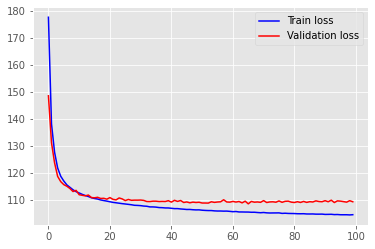

In [ ]:
plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    input, target = next(dataiter)
    print(input.size())
    data = input[1].to(device)
    data = data.view(1, 784)
    labels = target[1].to(device)
    labels = labels.view(1, 784)

    reconstruction, mu, log_var, bce, kl, loss ,z = model(data.float(),labels)
   

torch.Size([64, 1, 28, 28])


In [ ]:
input_img = input[1]
target_img = target[1]
out_img = reconstruction.cpu()
out_img = out_img.view(data.size(0), -1)
out_img = out_img.reshape(1,28,28)

In [ ]:
compare_images(input_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(63.81430583270661, 0.7374740874326123)

In [ ]:
compare_images(out_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(63.57959064561992, 0.7490786348750103)

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
axs[2].set_title('VAE_linear')

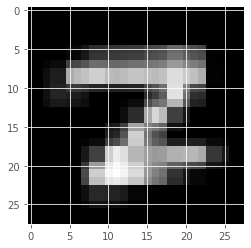

In [ ]:
plt.imshow(input_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

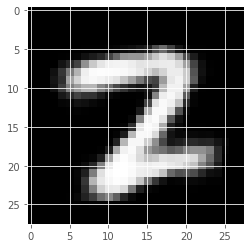

In [ ]:
plt.imshow(out_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

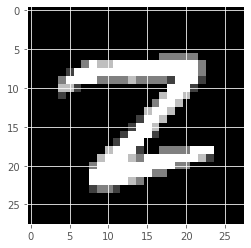

In [ ]:
plt.imshow(target_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

#### Test and Save

In [12]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [ ]:
#############################
#     TEST FUNCTION     #
############################
def test(model, dataloader):
    mse_loss = nn.functional.mse_loss
    model.eval()
    running_loss = 0.0
    mse_running_loss = 0.0
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            data_flat = data.view(data.size(0), -1)

            high_res = high_res.to(device)
            high_res_flat = high_res.view(data.size(0), -1)

            reconstruction, _, _, _, _, loss, _ = model(data_flat, high_res_flat)
            reconstruction = reconstruction.view((high_res.size(2), high_res.size(3), high_res.size(1)))
            high_res = high_res.view((high_res.size(2), high_res.size(3), high_res.size(1)))
             
            psnr, ssim = compare_images(high_res.cpu().numpy(), reconstruction.cpu().numpy())
            
            running_loss += loss.item()
            psnr_running_loss += psnr
            ssim_running_loss += ssim
            mse_running_loss += mse_loss(reconstruction, high_res)          
            
            
    test_loss = running_loss/len(dataloader.dataset)
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return test_loss, psnr, ssim, mse.cpu().item()


In [ ]:
test_loss, test_psnr, test_ssim, test_mse = test(model, val_loader)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
test_loss, test_psnr, test_ssim, test_mse

(111.56309619235992,
 65.93568213611333,
 0.7915821107596092,
 0.020511256530880928)

In [17]:
def metrics_on_loader(dataloader):
    mse_loss = nn.functional.mse_loss
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data
            data = data.cpu()
            high_res = high_res.cpu()
            
            _psnr, _ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).numpy(), data.view((data.size(2), data.size(3), data.size(1))).numpy())
            mse_running_loss += mse_loss(data.view((data.size(2), data.size(3), data.size(1))),high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))))
            
            psnr_running_loss += _psnr
            ssim_running_loss += _ssim            
            
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return psnr, ssim,mse


In [18]:
metrics_on_loader(val_loader)

  0%|          | 0/4000 [00:00<?, ?it/s]

(64.86188240406493, 0.7416098869853249, tensor(0.0221))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DTU/DL/Deep_Learning/Notebooks/Output/Models/vae_mnist.pth')

In [ ]:
dataiter = iter(val_loader)

In [ ]:
input, target = next(dataiter)

In [ ]:
input.size()

torch.Size([1, 1, 28, 28])

In [ ]:
im = target.squeeze(1)
im.size()

torch.Size([1, 28, 28])

In [ ]:
from torchvision.utils import save_image

save_image(im, '/content/drive/MyDrive/Deep_Learning/Data/images/MNIST5.png')